In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from datetime import timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
from prophet import Prophet

### Data Loading

In [27]:
file_path = 'data\\version-1-synthetics-data.csv'
df = pd.read_csv(file_path)
df.head()

,Date,sku_id,category,units sold,promotions,customers_visits,conversion_rate
0,2025-01-01,1072-071/OCEAN,End Tables,4,On Promotion,1193,0.0034
1,2025-01-02,1072-071/OCEAN,End Tables,2,On Promotion,680,0.0029
2,2025-01-03,1072-071/OCEAN,End Tables,1,On Promotion,287,0.0035
3,2025-01-04,1072-071/OCEAN,End Tables,2,On Promotion,546,0.0037
4,2025-01-05,1072-071/OCEAN,End Tables,0,On Promotion,731,0.0000


In [28]:
# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.head(5)

,Date,sku_id,category,units sold,promotions,customers_visits,conversion_rate
0,2025-01-01,1072-071/OCEAN,End Tables,4,On Promotion,1193,0.0034
19710,2025-01-01,628-015/0884-93,Sofas,3,On Promotion,1155,0.0026
18980,2025-01-01,848-026/HAZEL,Beds,1,On Promotion,189,0.0053
1460,2025-01-01,807-021H/FROSTWHITE,Headboards,0,On Promotion,663,0.0000
18250,2025-01-01,773-019/0336-82/JAVA,Sofas,1,Off Promotion,253,0.0040


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21900 entries, 0 to 21899
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              21900 non-null  datetime64[ns]
 1   sku_id            21900 non-null  object        
 2   category          21900 non-null  object        
 3   units sold        21900 non-null  int64         
 4   promotions        21900 non-null  object        
 5   customers_visits  21900 non-null  int64         
 6   conversion_rate   21900 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 1.3+ MB


### Feature Engineering (Exogenous Features)

In [30]:
# Encode Promotions (Binary)
df['promotions_binary'] = df['promotions'].apply(lambda x: 1 if x == 'On Promotion' else 0)

# Create Holiday Feature (US Calendar + 1 week early window)
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=df['Date'].min(), end=df['Date'].max())

holiday_dates = set()
for h in holidays:
    # "Consider 1 week early days as holiday" -> [Holiday - 7 days, Holiday]
    for i in range(8): 
        d = h - timedelta(days=i)
        holiday_dates.add(d)

df['Holiday'] = df['Date'].apply(lambda x: 1 if x in holiday_dates else 0)


In [31]:
df.head()

,Date,sku_id,category,units sold,promotions,customers_visits,conversion_rate,promotions_binary,Holiday
0,2025-01-01,1072-071/OCEAN,End Tables,4,On Promotion,1193,0.0034,1,1
19710,2025-01-01,628-015/0884-93,Sofas,3,On Promotion,1155,0.0026,1,1
18980,2025-01-01,848-026/HAZEL,Beds,1,On Promotion,189,0.0053,1,1
1460,2025-01-01,807-021H/FROSTWHITE,Headboards,0,On Promotion,663,0.0000,1,1
18250,2025-01-01,773-019/0336-82/JAVA,Sofas,1,Off Promotion,253,0.0040,0,1


### Exploratory Data Analysis (EDA)

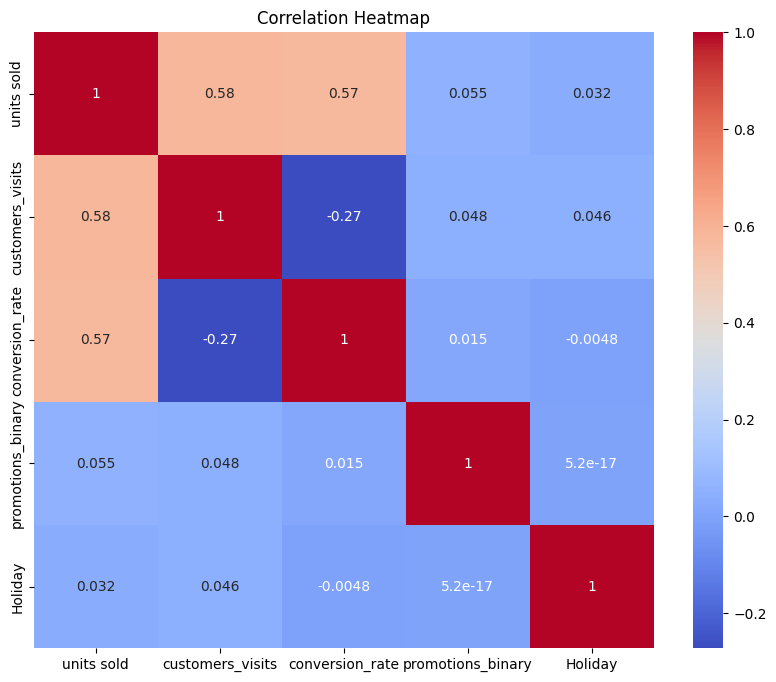

In [32]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
numeric_cols = ['units sold', 'customers_visits', 'conversion_rate', 'promotions_binary', 'Holiday']
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

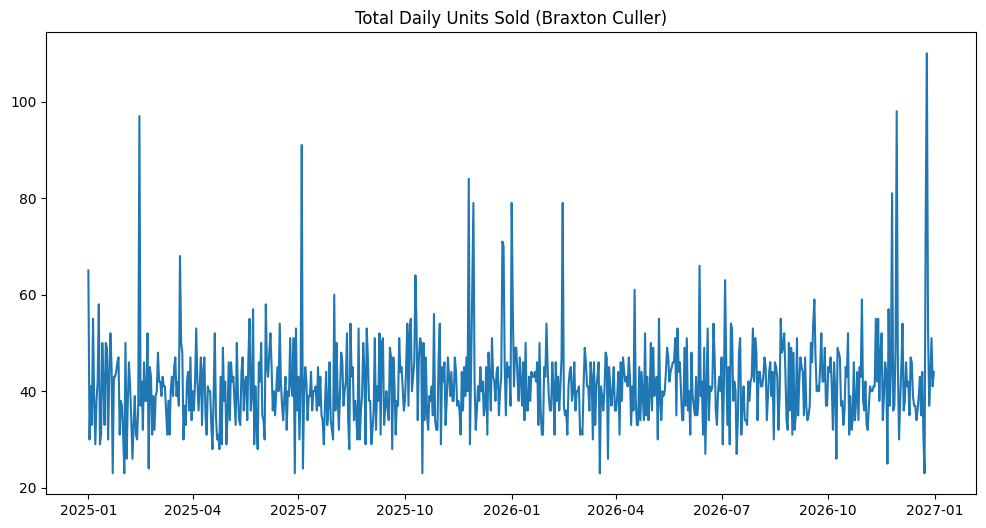

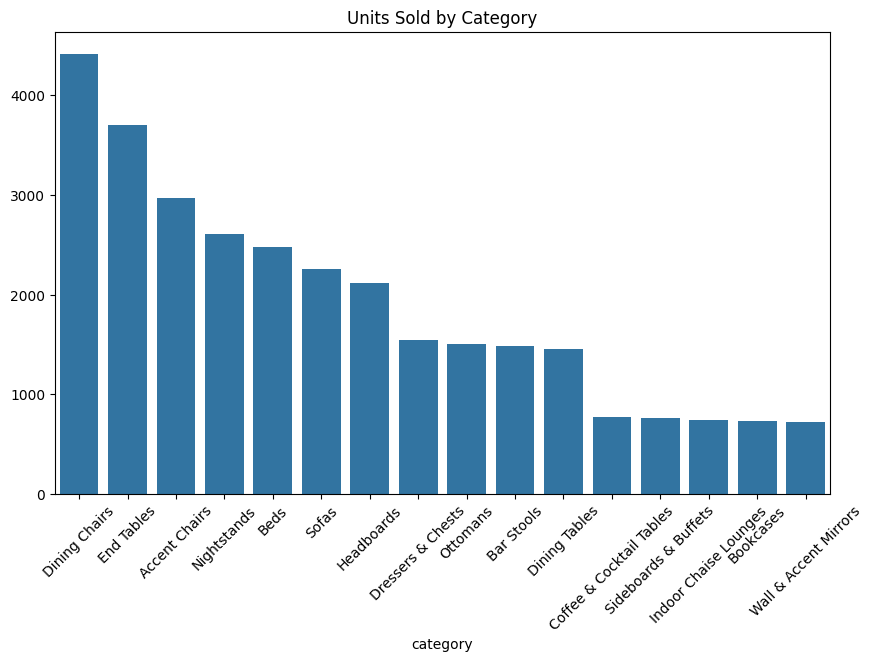

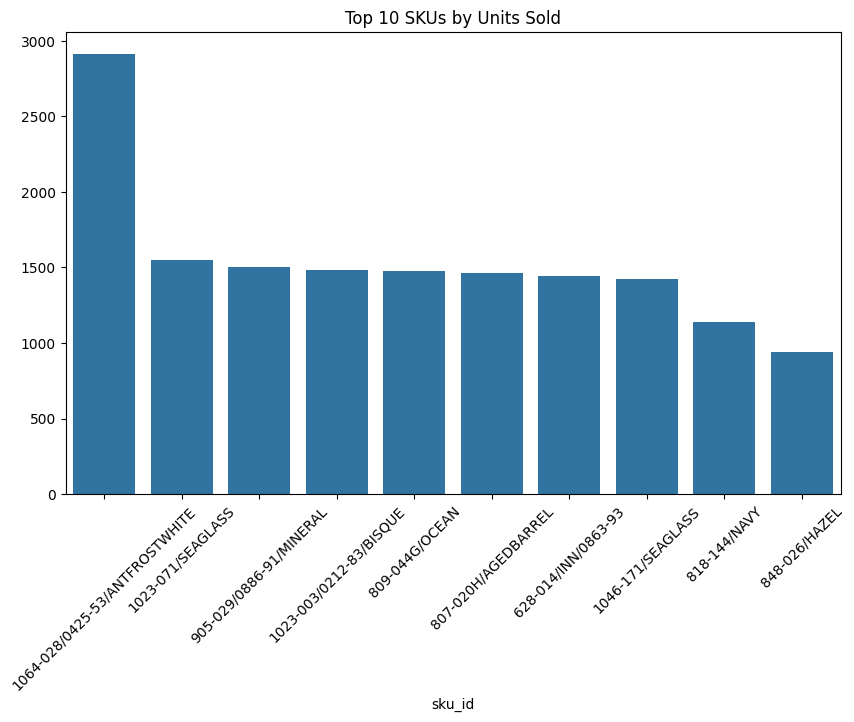

In [33]:
# Aggregated Daily Sales
daily_agg = df.groupby('Date').agg({
    'units sold': 'sum',
    'customers_visits': 'sum',
    'conversion_rate': 'mean',
    'promotions_binary': 'mean',
    'Holiday': 'max'
}).reset_index()
daily_agg.rename(columns={
    'units sold': 'y', 
    'customers_visits': 'total_visits',
    'conversion_rate': 'avg_conversion', 
    'promotions_binary': 'promo_ratio'
}, inplace=True)

# Plot Aggregated Sales
plt.figure(figsize=(12, 6))
plt.plot(daily_agg['Date'], daily_agg['y'])
plt.title('Total Daily Units Sold (Braxton Culler)')
plt.show()

# Visualizing Category & SKU Level
cat_sales = df.groupby('category')['units sold'].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=cat_sales.index, y=cat_sales.values)
plt.title('Units Sold by Category')
plt.xticks(rotation=45)
plt.show()

sku_sales = df.groupby('sku_id')['units sold'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=sku_sales.index, y=sku_sales.values)
plt.title('Top 10 SKUs by Units Sold')
plt.xticks(rotation=45)
plt.show()

## Seasonal Decomposition Visualization

<Figure size 1400x1000 with 0 Axes>

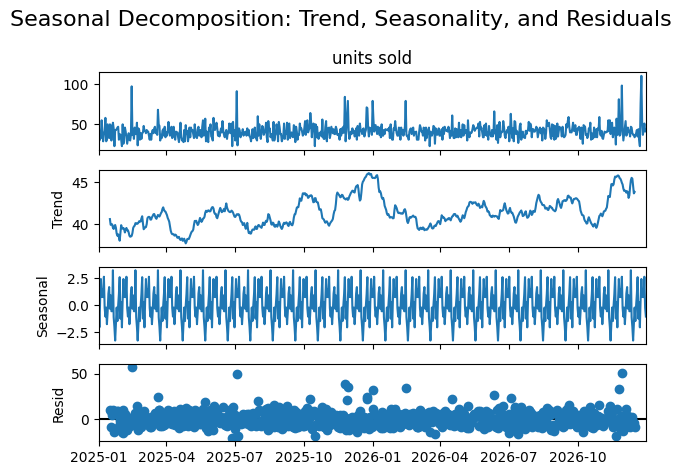

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# 1. Prepare Data: Ensure you have a Date index
# We use the aggregated daily sales calculated earlier
daily_sales = df.groupby('Date')['units sold'].sum()

# 2. Decompose the Time Series
# 'period=7' looks for weekly patterns. Use 30 for monthly, 365 for yearly.
# 'model="additive"' assumes seasonality is constant (independent of trend).
decomposition = seasonal_decompose(daily_sales, model='additive', period=30)

# 3. Plot the Components
plt.figure(figsize=(14, 10))
decomposition.plot()
plt.suptitle('Seasonal Decomposition: Trend, Seasonality, and Residuals', fontsize=16)
plt.tight_layout()  # Adjusts plot to fit the title
plt.show()

#### CREATE LAG FEATURES 

In [35]:
# Lag 1: Sales from Yesterday
daily_agg['y_lag_1'] = daily_agg['y'].shift(1)

# Lag 7: Sales from Last Week (Same day previous week)
daily_agg['y_lag_7'] = daily_agg['y'].shift(7)

# Rolling Mean: Average sales of the previous 7 days (Moving Average)
# Note: We shift(1) first to ensure we don't include "Today" in the average (Data Leakage prevention)
daily_agg['y_roll_mean_7'] = daily_agg['y'].shift(1).rolling(window=7).mean()


In [51]:
model_df = daily_agg.dropna().reset_index(drop=True)

print(f"Data shape after creating lags: {model_df.shape}")
model_df.head(10)


Data shape after creating lags: (723, 9)


,Date,y,total_visits,avg_conversion,promo_ratio,Holiday,y_lag_1,y_lag_7,y_roll_mean_7
0,2025-01-08,38,17973,0.002527,0.666667,0,29.0,65.0,41.571429
1,2025-01-09,42,17378,0.002763,0.666667,0,38.0,30.0,37.714286
2,2025-01-10,58,21329,0.002843,0.666667,0,42.0,41.0,39.428571
3,2025-01-11,29,17349,0.002147,0.666667,0,58.0,33.0,41.857143
4,2025-01-12,31,18829,0.001910,0.666667,0,29.0,55.0,41.285714
5,2025-01-13,50,21443,0.002580,0.666667,1,31.0,38.0,37.857143
6,2025-01-14,42,17327,0.002657,0.666667,1,50.0,29.0,39.571429
7,2025-01-15,33,16352,0.002370,0.666667,1,42.0,38.0,41.428571
8,2025-01-16,50,15006,0.003400,0.666667,1,33.0,42.0,40.714286
9,2025-01-17,49,20003,0.002650,0.666667,1,50.0,58.0,41.857143


### 5. XGBoost Model Training

In [37]:
features = ['total_visits', 
    'avg_conversion', 
    'promo_ratio', 
    'Holiday',
    'y_lag_1',       # New Feature
    'y_lag_7',       # New Feature
    'y_roll_mean_7']
target = 'y'


### Data Splitting (1.5 Years Train, 0.5 Years Test)

In [38]:


# Split based on time
split_date = model_df['Date'].min() + timedelta(days=547)

X_train = model_df[model_df['Date'] < split_date][features]
y_train = model_df[model_df['Date'] < split_date][target]

X_test = model_df[model_df['Date'] >= split_date][features]
y_test = model_df[model_df['Date'] >= split_date][target]
test_dates = model_df[model_df['Date'] >= split_date]['Date']


In [39]:

# Initialize and Train
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=1000, 
    learning_rate=0.01,
    max_depth=5
)
xgb_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [40]:
X_train.head()

,total_visits,avg_conversion,promo_ratio,Holiday,y_lag_1,y_lag_7,y_roll_mean_7
0,17973,0.002527,0.666667,0,29.0,65.0,41.571429
1,17378,0.002763,0.666667,0,38.0,30.0,37.714286
2,21329,0.002843,0.666667,0,42.0,41.0,39.428571
3,17349,0.002147,0.666667,0,58.0,33.0,41.857143
4,18829,0.001910,0.666667,0,29.0,55.0,41.285714


In [41]:
# Forecast
xgb_pred = xgb_model.predict(X_test)

In [42]:
# Evaluation
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_mae = mean_absolute_error(y_test, xgb_pred)
print(f"XGBoost Performance -  MAE: {xgb_mae:.2f}, RMSE: {xgb_rmse:.2f}")

XGBoost Performance -  MAE: 2.72, RMSE: 4.38


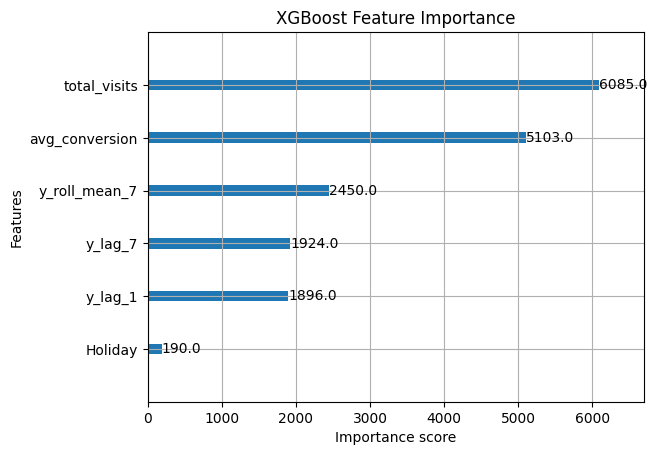

In [43]:
# Feature Importance
xgb.plot_importance(xgb_model)
plt.title('XGBoost Feature Importance')
plt.show()

### Prophet Model Implementaation

In [ ]:
# Prepare data for Prophet (ds, y format)
prophet_train = X_train[['Date', 'y', 'total_visits', 'avg_conversion', 'promo_ratio', 'Holiday']].rename(columns={'Date': 'ds'})
prophet_test = X_test[['Date', 'y', 'total_visits', 'avg_conversion', 'promo_ratio', 'Holiday']].rename(columns={'Date': 'ds'})

In [45]:
prophet_train

,ds,y,total_visits,avg_conversion,promo_ratio,Holiday
0,2025-01-01,65,25715,0.002800,0.666667,1
1,2025-01-02,30,14730,0.002467,0.666667,0
2,2025-01-03,41,18072,0.002353,0.666667,0
3,2025-01-04,33,16636,0.002237,0.666667,0
4,2025-01-05,55,22874,0.002590,0.666667,0
...,...,...,...,...,...,...
542,2026-06-27,33,15654,0.002543,0.666667,1
543,2026-06-28,40,19048,0.002357,0.666667,1
544,2026-06-29,43,17144,0.002677,0.666667,1
545,2026-06-30,40,16138,0.002893,0.666667,1


In [46]:
m = Prophet()
# Add exogenous features (regressors)
m.add_regressor('total_visits')
m.add_regressor('avg_conversion')
m.add_regressor('promo_ratio')
m.add_regressor('Holiday')

m.fit(prophet_train)

14:25:29 - cmdstanpy - INFO - Chain [1] start processing
14:25:30 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
# Predict
forecast = m.predict(prophet_test.drop(columns=['y']))
prophet_pred = forecast['yhat'].values

In [48]:
# Evaluation
prophet_rmse = np.sqrt(mean_squared_error(test_df['y'], prophet_pred))
prophet_mae = mean_absolute_error(test_df['y'], prophet_pred)
print(f"Prophet Performance -  MAE: {prophet_mae:.2f}, RMSE: {prophet_rmse:.2f}")

Prophet Performance -  MAE: 2.14, RMSE: 2.87


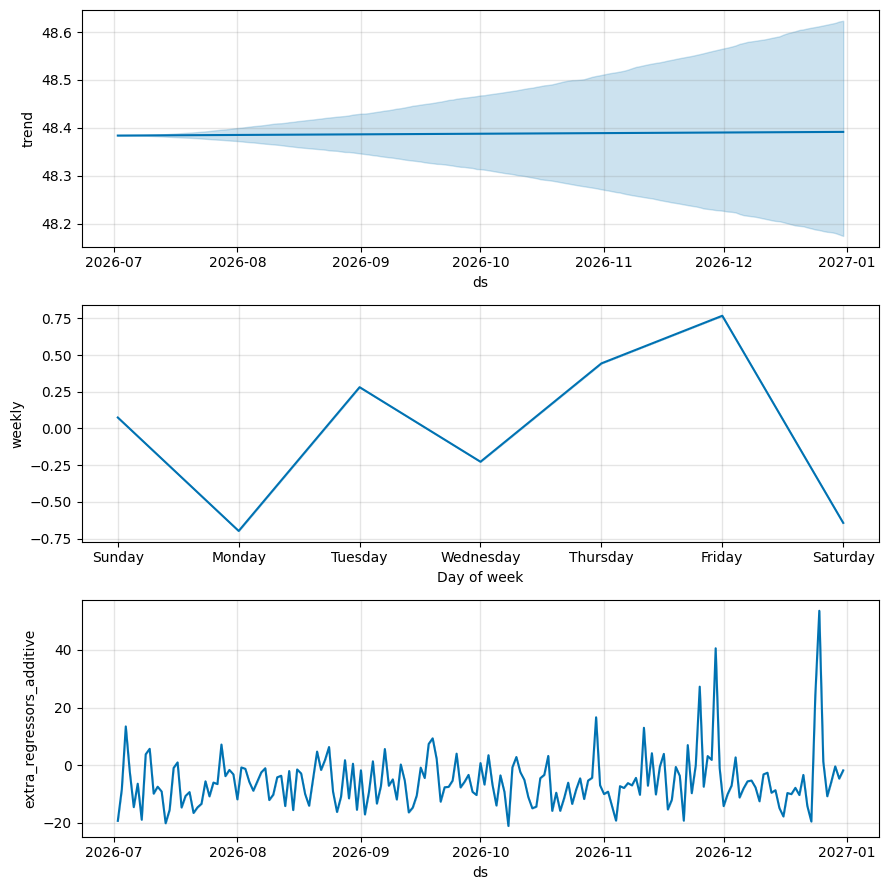

In [49]:
# Plot Components
m.plot_components(forecast)
plt.show()

### Comparison Graph


ValueError: x and y must have same first dimension, but have shapes (183,) and (176,)

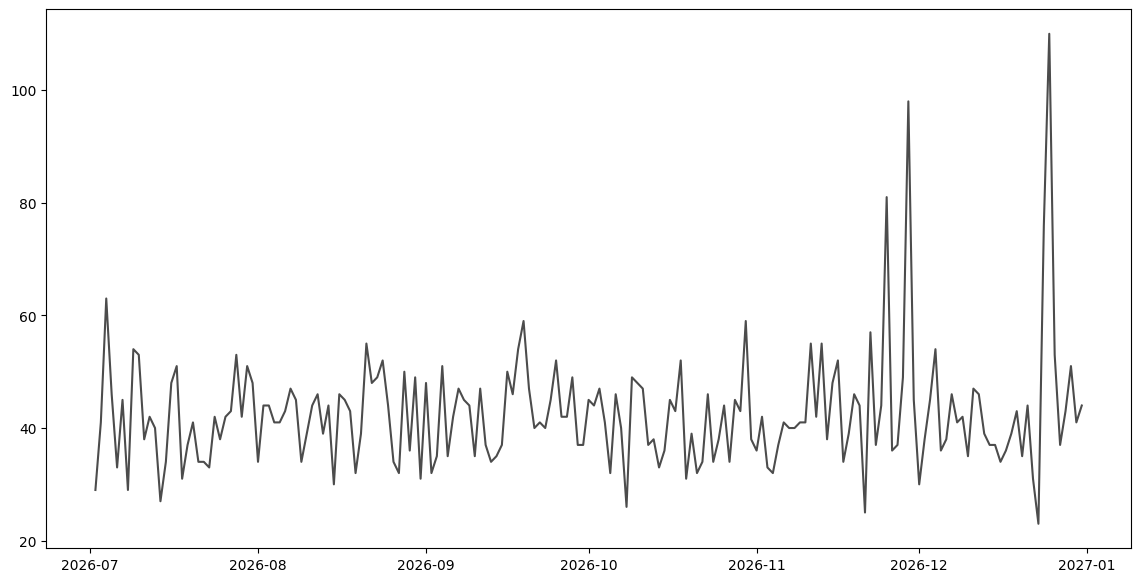

In [50]:

plt.figure(figsize=(14, 7))
plt.plot(test_df['Date'], test_df['y'], label='Actual', color='black', alpha=0.7)
plt.plot(test_df['Date'], xgb_pred, label=f'XGBoost (RMSE={xgb_rmse:.2f})', linestyle='--', color='blue')
plt.plot(test_df['Date'], prophet_pred, label=f'Prophet (RMSE={prophet_rmse:.2f})', linestyle='-.', color='orange')
plt.title('Demand Forecasting Comparison: Actual vs XGBoost vs Prophet')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.show()